**Advanced Machine Learning (Semester 1 2023)**
# 3 Artificial Neural Networks (II)


*N. Hernitschek, 2023*


This Jupyter notebook gives a deeper insight into the mechanisms of neural networks.

---
## Contents
* [The Benefits of a Neural Network](#first-bullet)
* [Preparation for next time](#second-bullet)
* [Summary](#third-bullet)

## 1. The Benefits of a Neural Network <a class="anchor" id="first-bullet"></a>


Other than in the previous notebook where the focus was on understanding the building blocks of a neural network, we're here using a more realistic **vectorized implementation** that also allows us to flexibly change the neural network's architecture.

     
In this section we'll walk through a complete implementation of a toy Neural Network in 2 dimensions.

We start with implementing a simple linear classifier and then extend the code to a 2-layer Neural Network.

### Generating Data

Let's generate a classification dataset that is not easily linearly separable. A data set that looks like a spiral galaxy with four arms can be generated the following way:



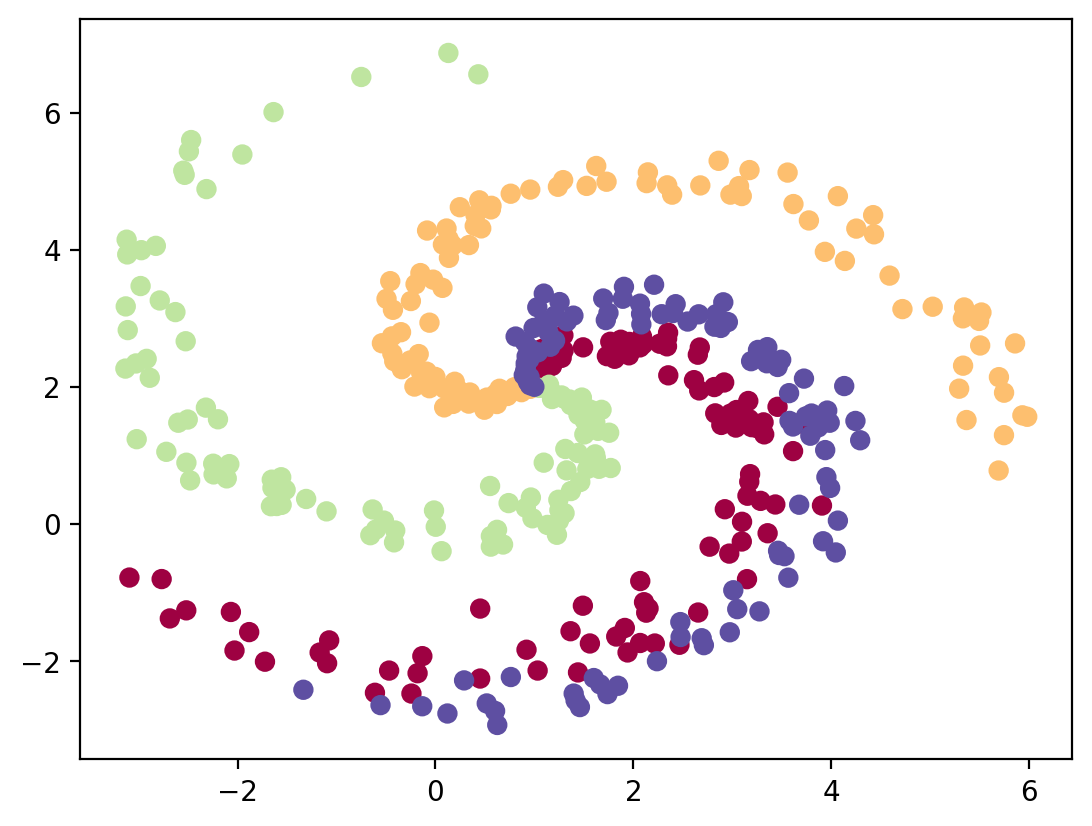

In [1]:

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

N = 100 # number of points per class
D = 2 # dimensionality
K = 4 #3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]*5+[1,2]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


The toy spiral data consists of four classes (here shown in purple, red, green, orange) that are not linearly separable. In addition, two of the "spiral galaxy's arms" are very close to each other, making it even more difficult.

We preprocess the dataset so that each feature has zero mean and unit standard deviation:

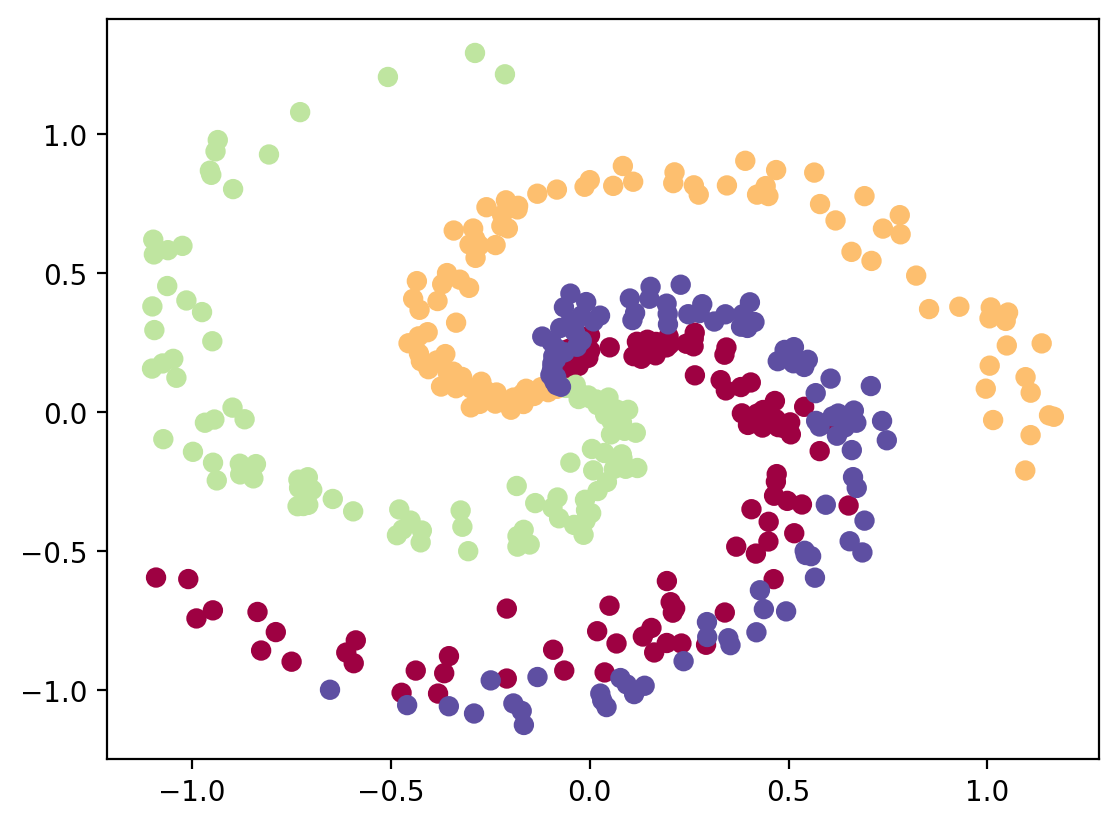

In [2]:
mean_x = np.mean(X[:, 0])
#print(mean_x)
mean_y = np.mean(X[:, 1])
#print(mean_y)

std_x = np.std(X[:, 0])
#print(std_x)
std_y = np.std(X[:, 1])
#print(std_y)

X[:, 0] = (X[:, 0]-mean_x)/(2.0*std_x)
X[:, 1] = (X[:, 1]-mean_y)/(2.0*std_y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

### Training a Softmax Linear Classifier

We first train a Softmax classifier on this classification dataset. The Softmax classifier is a classifier comparable to a SVM, having a linear score function and using the cross-entropy loss. 

<img src="images/softmax_classifier.png?modified=1344756789" width="600"/>

A Softmax classifier provides **probabilities** for each class. Unlike the SVM which computes uncalibrated and not easy to interpret scores for all classes, the Softmax classifier allows us to compute probabilities within [0,1] for all labels. For example, given an image the SVM classifier might give you scores [12.4, 0.6, -17.1] for the classes “star”, “asteroid” and “galaxy”. The softmax classifier can instead compute the probabilities of the three labels as [0.9, 0.09, 0.01], which allows you to interpret its confidence in each class.


#### Initialize the parameters

The parameters of the linear classifier consist of a weight matrix $W$ and a bias vector $b$ for each class. Lets first initialize these parameters to be random numbers:


In [3]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K) # D = 2 is the dimensionality and K = 4 is the number of classes
b = np.zeros((1,K))


#### Compute the class scores

Since this is a linear classifier, we can compute all class scores very simply in parallel with a single matrix multiplication:

In [4]:
# compute class scores for a linear classifier
scores = np.dot(X, W) + b

In this example we have 100 2-D points, so after this multiplication the array scores will have size [100 x 4], where each row gives the class scores corresponding to the 4 classes.

#### Compute the loss

The second key ingredient we need is a loss function, which is a differentiable objective that quantifies our unhappiness with the computed class scores.


Recall also that the full Softmax classifier loss is then defined as the average cross-entropy loss over the training examples and the regularization:

$L =   \frac{1}{N} \sum_i L_i  +\frac{1}{2} \lambda \sum_k\sum_l W_{k,l}^2 $

Given the array of scores we computed above, we can now compute the loss. First, the way to obtain the probabilities is straight forward:


In [5]:
num_examples = X.shape[0]
# get unnormalized probabilities
exp_scores = np.exp(scores)
# normalize them for each example
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


We now have an array probs of size [100 x 4], where each row contains the class probabilities. We can now query for the log probabilities assigned to the correct classes in each example:

In [6]:
correct_logprobs = -np.log(probs[range(num_examples),y])


The array `correct_logprobs` is a 1D array of just the probabilities assigned to the correct classes for each example. The full loss is then computed as the average of these log probabilities and the regularization loss:

In [7]:

# compute the loss: average cross-entropy loss and regularization

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

data_loss = np.sum(correct_logprobs)/num_examples
reg_loss = 0.5*reg*np.sum(W*W)
loss = data_loss + reg_loss

In this code, the regularization strength $\lambda$
is stored inside the variable `reg`. The convenience factor of 0.5 multiplying the regularization will become clear in a second. Evaluating this in the beginning (with random parameters) might give us loss = 1.1, which is -np.log(1.0/3), since with small initial random weights all probabilities assigned to all classes are about one third. We now want to make the loss as low as possible, with loss = 0 as the absolute lower bound. But the lower the loss is, the higher are the probabilities assigned to the correct classes for all examples.

#### Computing the Analytic Gradient with Backpropagation

As we now have a way of evaluating the loss, we can continue with minimizing it. We do so with **gradient descent**.

In the following code, recall that `probs` stores the probabilities of all classes (as rows) for each example. To get the gradient on the scores, which we call `dscores`, we proceed as follows:


In [8]:
dscores = probs
dscores[range(num_examples),y] -= 1
dscores /= num_examples



Lastly, we had that `scores = np.dot(X, W) + b`, so with the gradient on scores (stored in `dscores`), we can now backpropagate into `W` and `b`:


In [94]:

dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dW += reg*W # don't forget the regularization gradient


Now that we've evaluated the gradient we know how every parameter influences the loss function. We will now perform a **parameter update** in the negative gradient direction in order to decrease the loss:



In [24]:
# perform a parameter update
W += -step_size * dW
b += -step_size * db


**Here is the complete code for Training a Softmax Classifier with Gradient descent:**

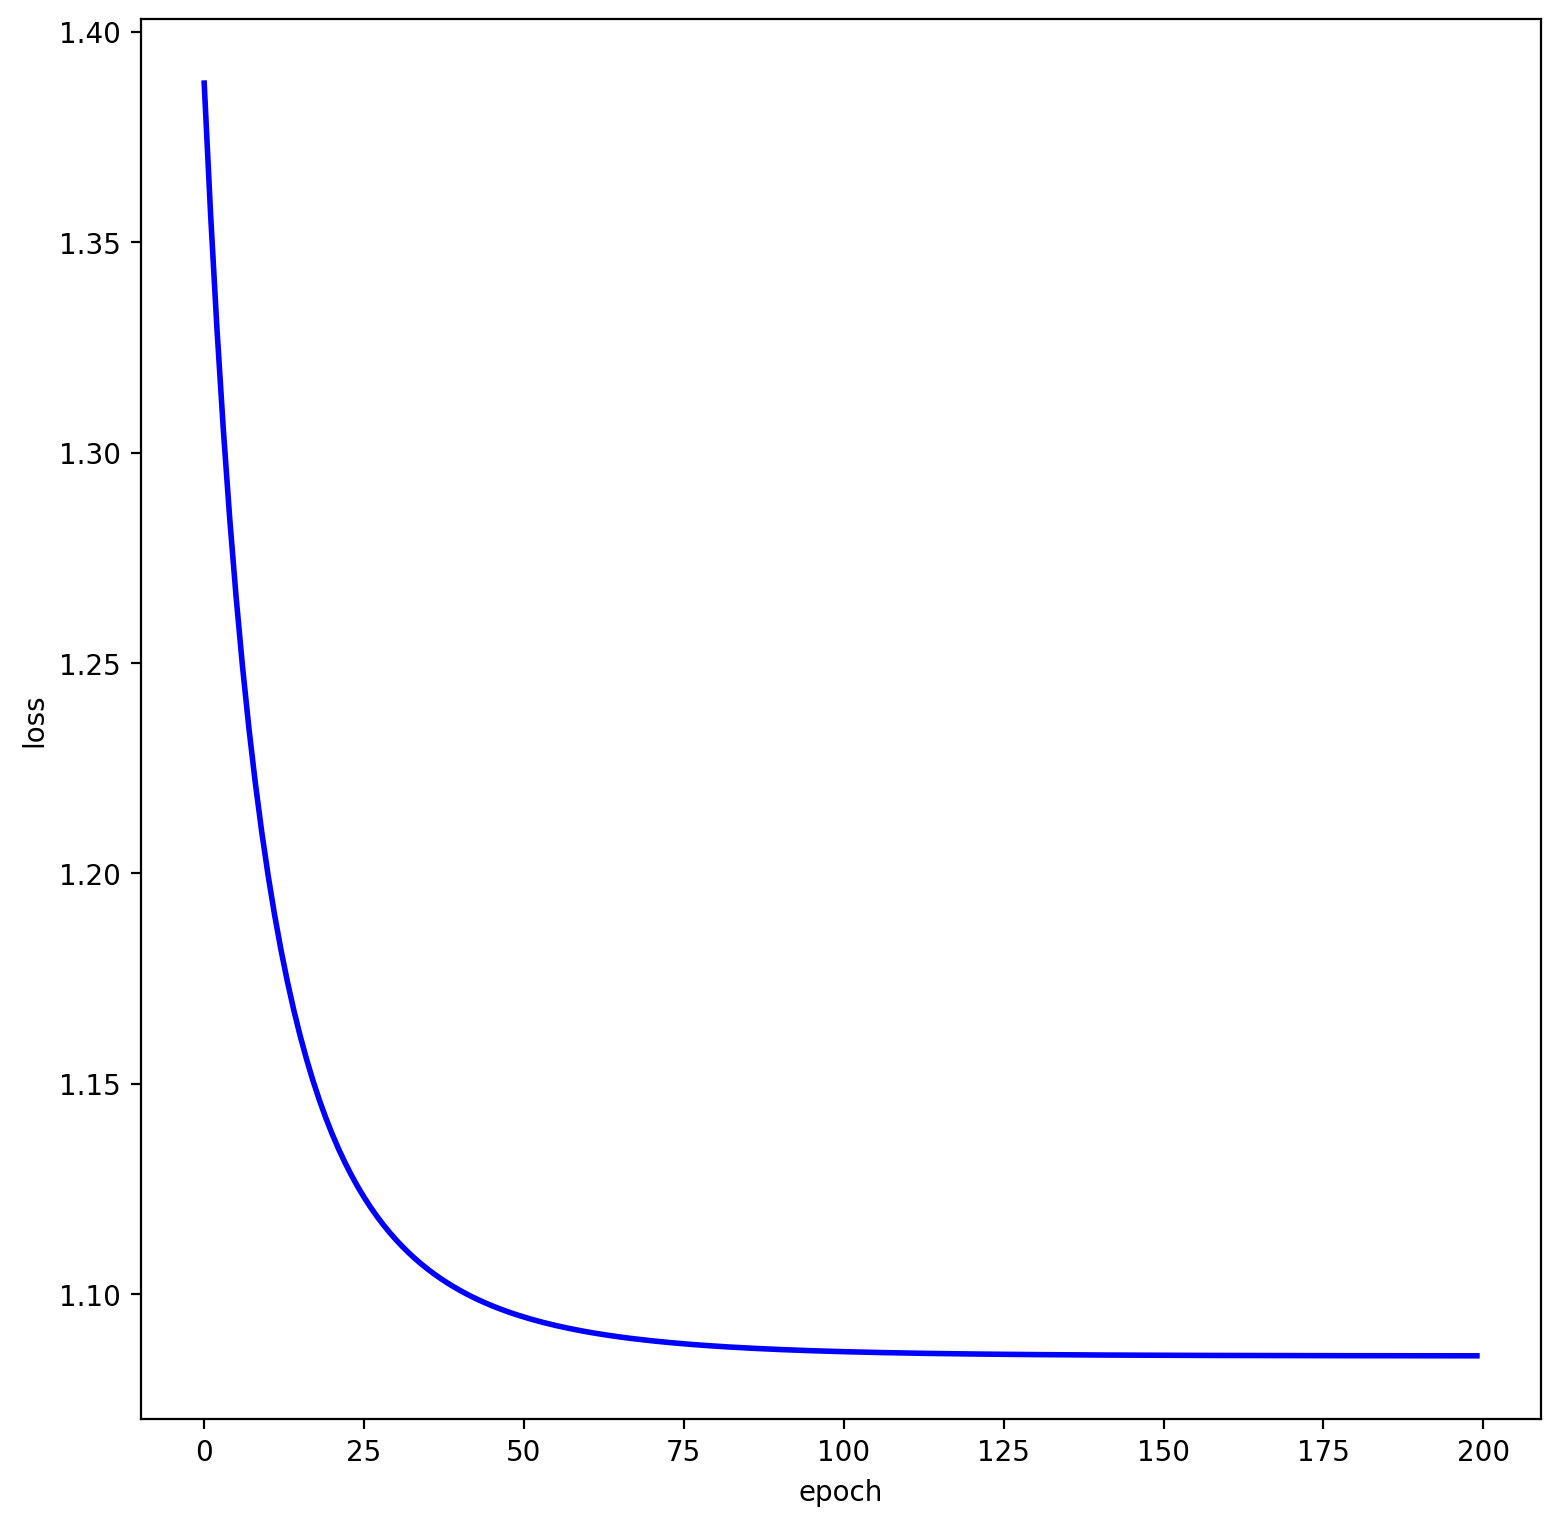

In [9]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]

epoch_vector = []
loss_vector = []

for i in range(200):

  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b

  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  #if i % 10 == 0:
  #  print ("iteration %d: loss %f" % (i, loss))
    
    
  epoch_vector.append(i)
  loss_vector.append(loss)
      
        

  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples

  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)

  dW += reg*W # regularization gradient

  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db



fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0,0,1,1])
ax.plot(epoch_vector,loss_vector, '-b', lw=2)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()
  


We see that we've converged to something after about 150 iterations. We can evaluate the training set accuracy:



In [10]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))



training accuracy: 0.38


(-2.125183234738819, 2.274816765261185)

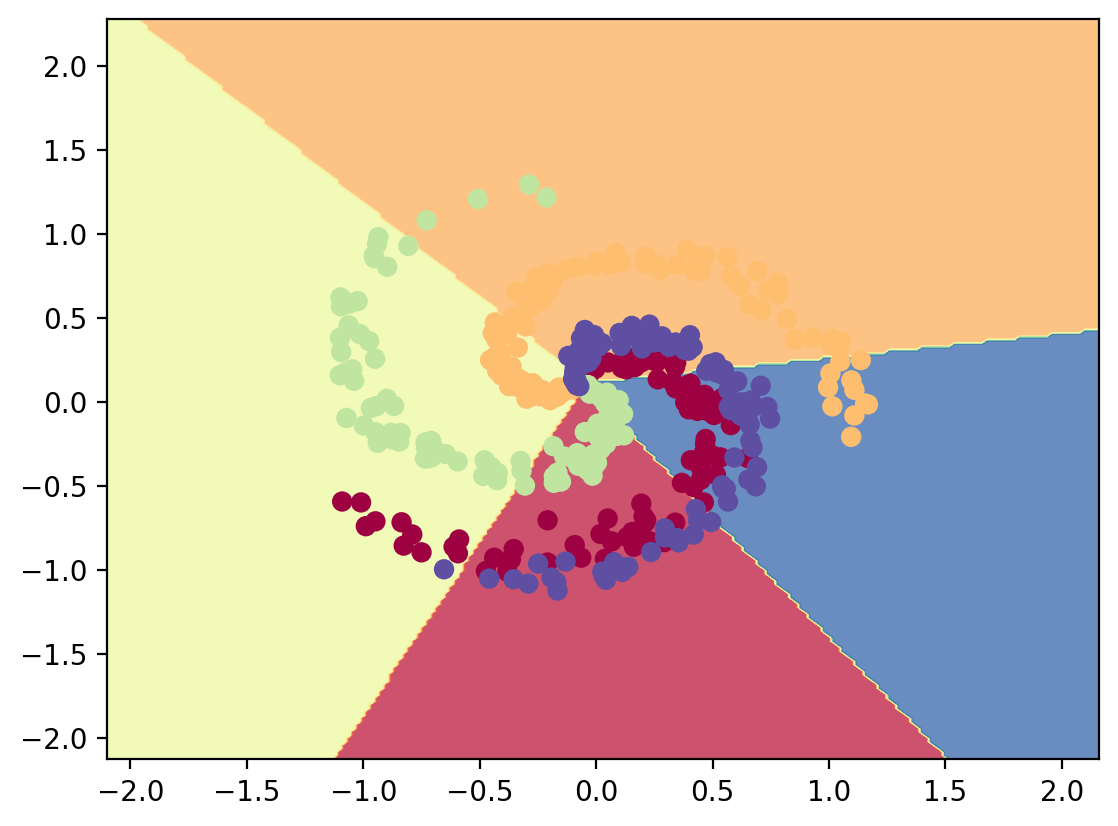

In [11]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

The training accuracy is only 0.39. This is not a good result, but also not surprising given that the dataset is constructed so it is **not linearly separable**. The plotted learned decision boundaries reflect this result.



### Training a Neural Network

Clearly, a linear classifier is inadequate for this dataset and we would like to use a Neural Network with a hidden layer. One additional hidden layer will suffice for this toy data. We will now need two sets of weights and biases (for the first and second layers):

In [12]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))


The forward pass to compute scores now changes form, and a **ReLU activation function** is introduced:

ReLU stands for Rectified Linear Unit. Although it gives an impression of a linear function, ReLU has a derivative function and allows for backpropagation while simultaneously making it computationally efficient. 

<img src="images/relufunction_derivative.png?modified=134756789" width="400"/>

<br>
<br>
<br>

\begin{align*}
\varphi(z)& = \mathrm{max}(0,z)\\
\varphi'(z)&=\begin{cases}
    1, & \text{if $z \geq 0$}\\
    0, & \text{otherwise}.
  \end{cases}
\end{align*}



In [74]:
# evaluate class scores with a 2-layer Neural Network
hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
scores = np.dot(hidden_layer, W2) + b2


Notice that the only change from before is one extra line of code: to first compute the hidden layer representation and then the scores based on this hidden layer. 
Crucially, we have also added a non-linearity, which in this case is simple ReLU that thresholds the activations on the hidden layer at zero.

Everything else remains the same.

What now changes is of course the way we **backpropagate** that gradient into the model parameters now changes form, of course. First lets backpropagate the second layer of the Neural Network. This looks identical to the code we had for the Softmax classifier, except we’re replacing `X` (the raw data), with the variable `hidden_layer`):

In [32]:
# backpropate the gradient to the parameters

# first backprop into parameters W2 and b2
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)


We are not done yet as `hidden_layer` is itself a function of other parameters and the data. We have to continue backpropagation through this variable. Its gradient can be computed as:

In [33]:
dhidden = np.dot(dscores, W2.T)

Now we have the gradient on the outputs of the hidden layer. Next, we have to backpropagate the ReLU non-linearity. This turns out to be easy because ReLU during the backward pass is effectively a switch. Since $r=max(0,x)$, we have that $dr/dx=1(x>0)$. Combined with the chain rule, we see that the ReLU unit lets the gradient pass through unchanged if its input was greater than 0, but kills it if its input was less than zero during the forward pass. 

Hence, we can backpropagate the ReLU in place simply with:

In [34]:
# backprop the ReLU non-linearity
dhidden[hidden_layer <= 0] = 0


And now we finally continue to the first layer weights and biases:


In [35]:
# finally into W,b
dW = np.dot(X.T, dhidden)
db = np.sum(dhidden, axis=0, keepdims=True)


With this, we're done. We have the gradients `dW`, `db`, `dW2`, `db2` and can perform the parameter update. Everything else remains unchanged. The full code looks very similar:


**Here is the complete code for Training a Softmax Classifier with Gradient descent:**

In [13]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

epoch_vector = []
loss_vector = []

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):

  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2

  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  #if i % 1000 == 0:
  #  print ("iteration %d: loss %f" % (i, loss))
  epoch_vector.append(i)
  loss_vector.append(loss)

  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples

  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)

  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W

  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2


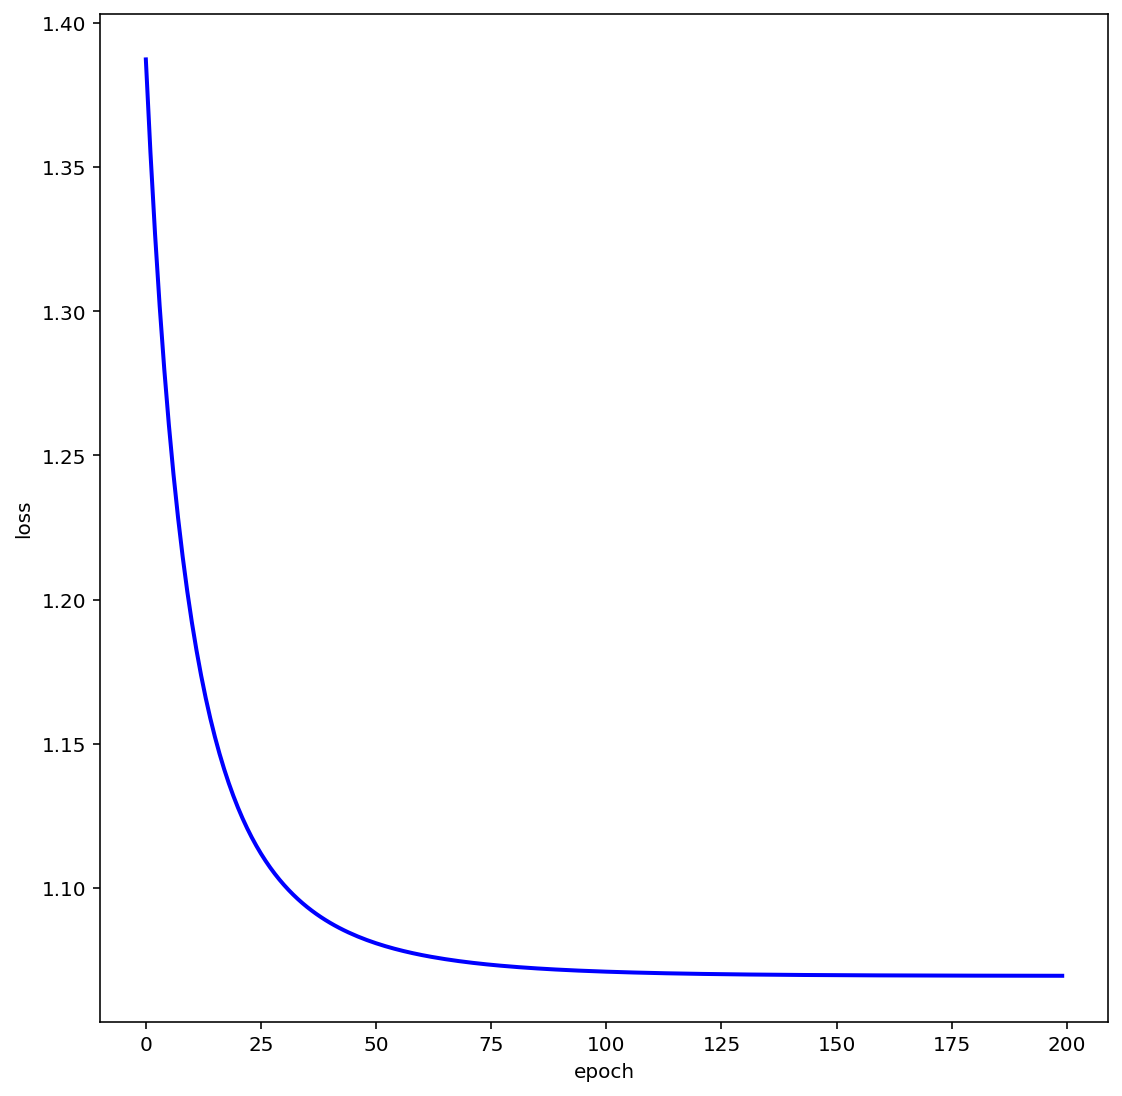

In [99]:

fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0,0,1,1])
ax.plot(epoch_vector,loss_vector, '-b', lw=2)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()


The training accuracy is now:

In [14]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))



training accuracy: 0.90


Which prints 90%! We can also visualize the decision boundaries:

(-2.125183234738819, 2.274816765261185)

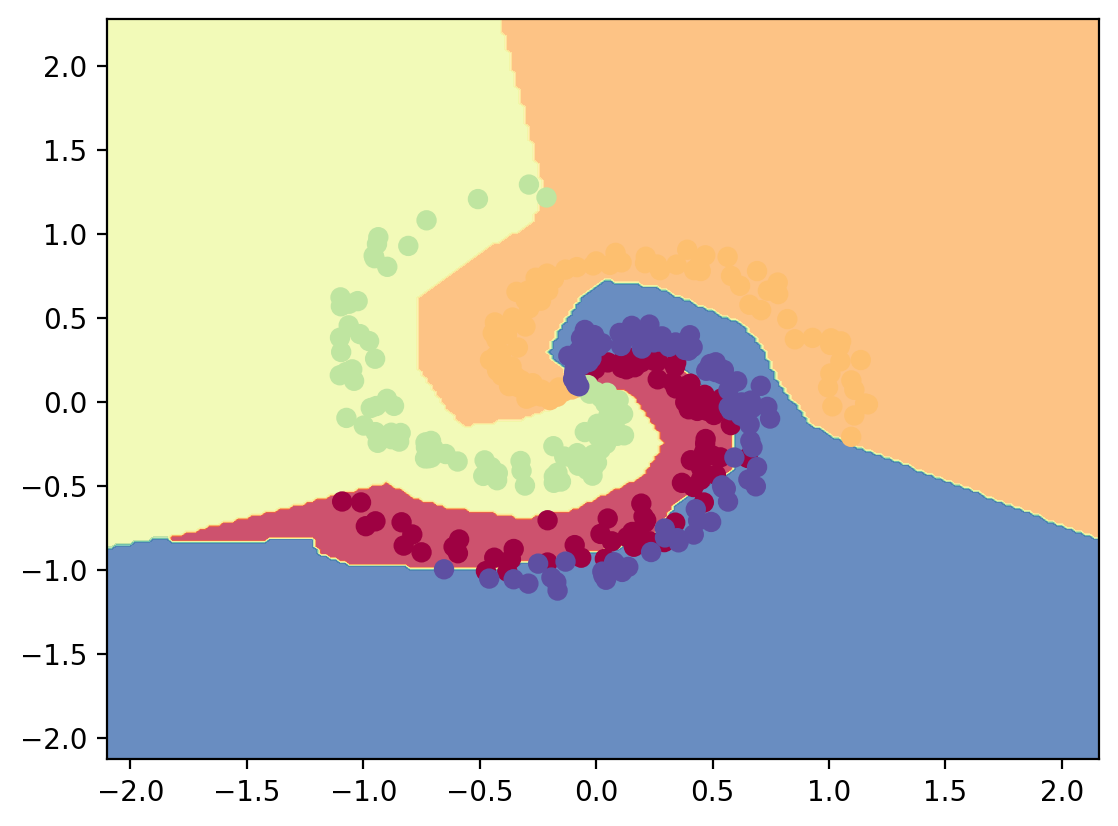

In [15]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')

We now create new new data from the same model and and classify them:

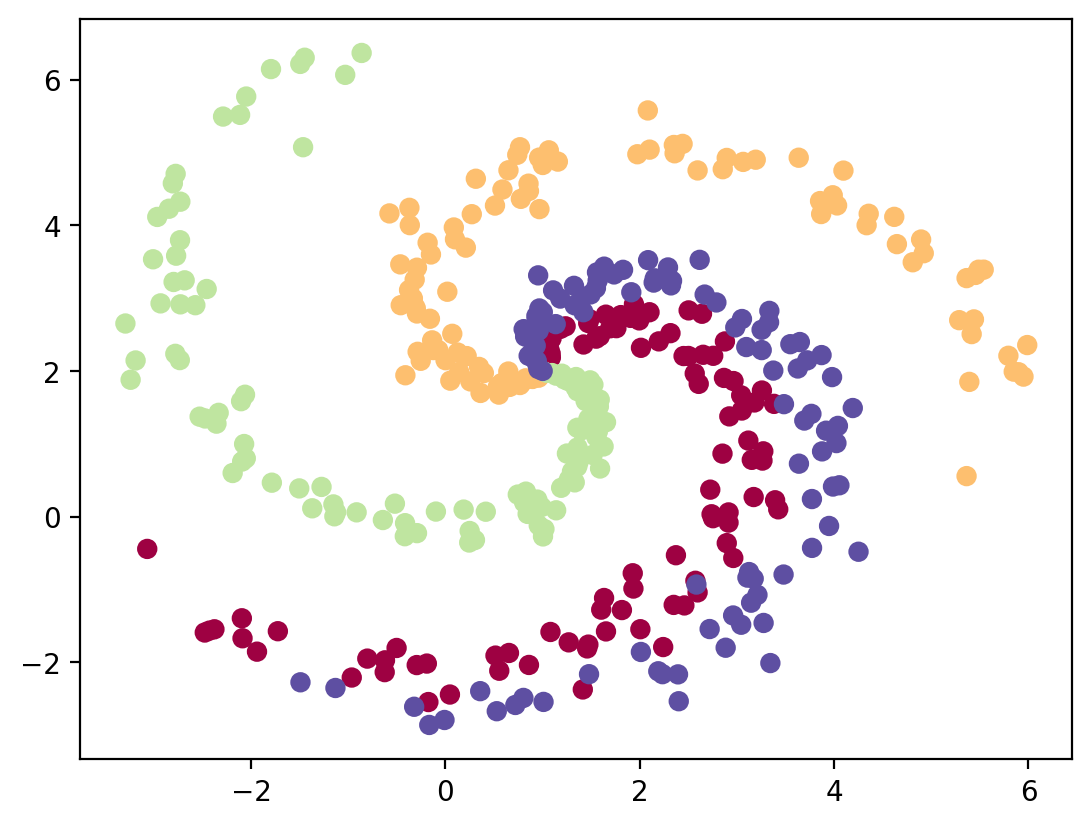

In [16]:

N = 100 # number of points per class
D = 2 # dimensionality
K = 4 #3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]*5+[1,2]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


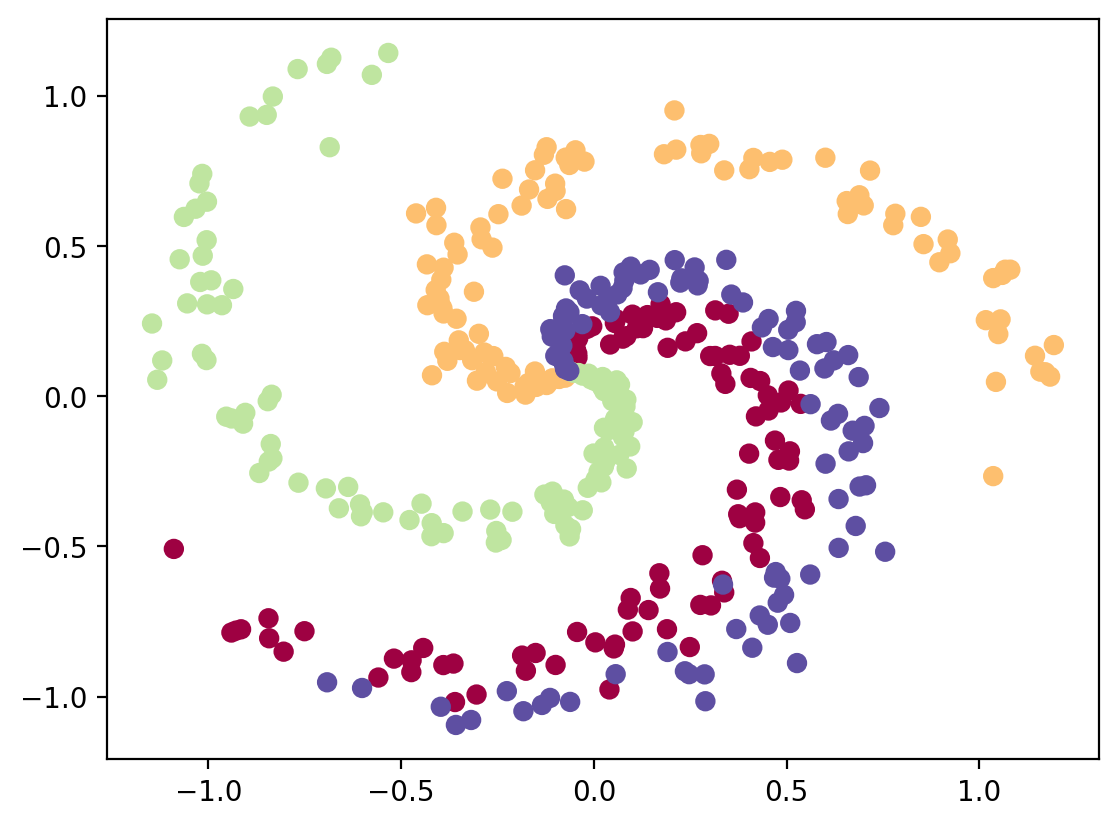

In [17]:
mean_x = np.mean(X[:, 0])
#print(mean_x)
mean_y = np.mean(X[:, 1])
#print(mean_y)

std_x = np.std(X[:, 0])
#print(std_x)
std_y = np.std(X[:, 1])
#print(std_y)

X[:, 0] = (X[:, 0]-mean_x)/(2.0*std_x)
X[:, 1] = (X[:, 1]-mean_y)/(2.0*std_y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [18]:
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('classification accuracy: %.2f' % (np.mean(predicted_class == y)))

classification accuracy: 0.90


# <font color='dodgerblue'>Things to try out:</font>


*  What happens when one example in the training set is labelled wrong?
*  What happens when training runs longer or shorter?
*  What happens when the activation function is modified?
*  Which problems do you see in the implementation here?
*  What happens when you change the activation function?
*  What happens if there is no activation function at all?
*  Try to make changes to the data set: What happens when you have a more complicated 2D dataset? A 3D dataset?


## Preparation for next time <a class="anchor" id="second-bullet"></a>

Select and read an astronomy paper of your choice that uses machine learning.
Try to understand as much as possible. We have time for discussion next time! (No need to finish a presentation yet.) Outlook: In the session on May 15, you are expected to give a 15-minute presentation on the selected paper and highlight especially the machine-learning/ neural network content of that paper.

## Summary <a class="anchor" id="third-bullet"></a>

At this point, all of you should have:
* seen how a complete vectorized neural network works
* seen how and why a neural network can outperform linear classifiers
* got a deeper understanding of the building blocks of a neural network.



